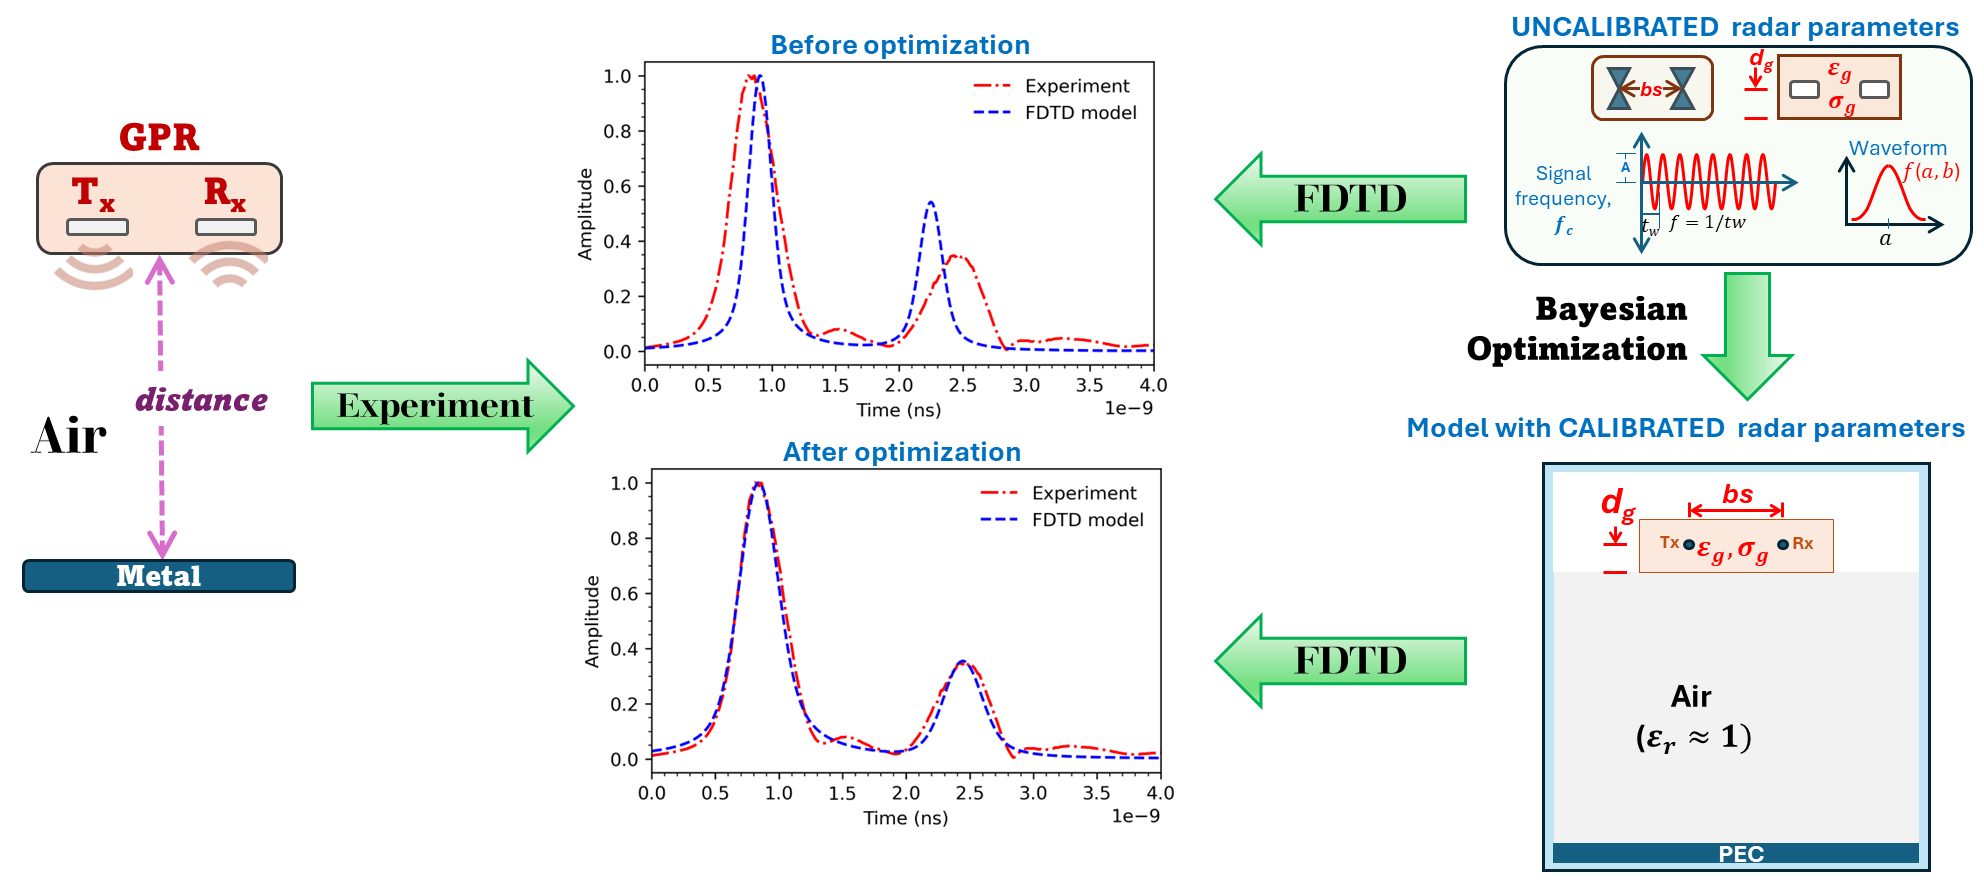

# Packages and Utility functions

#### All necessary packages and gprMax need to be installed to run the following codes

In [1]:
import numpy as np; 
import pandas as pd; 
import matplotlib.pyplot as plt; 
plt.rcParams['figure.figsize'] = (10, 2);
from gprMax.utilities import detect_check_gpus; 
from gprMax.gprMax import api; 
import h5py; 
detect_check_gpus([1]);
import os; 
import torch
import time; 
from IPython.display import clear_output; 
os.getcwd(); 
from GPUtil import showUtilization as gpu_usage
from numba import cuda; 
import gc; 
import pycuda.driver; 
import random; 
from scipy.signal import hilbert
from bayes_opt import BayesianOptimization; 

def free_gpu_cache():
    gc.collect(); 
    torch.cuda.empty_cache(); 
    cuda.select_device(1); 
    cuda.close(); 
    cuda.select_device(1); 
    gpu_usage()
free_gpu_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

| ID | GPU | MEM |
------------------
|  0 | 10% |  1% |
|  1 |  6% |  1% |


In [2]:
## Function to 
#   1. MATCH LENGTH of experimental and numerical signal, 
#   2. Perform HILBERT TRANSFORM to get amplitude envelope and
#   3. NORMALIZE both experimental and numerical A-scans

def signal_length_matching(smaller,longer):
    # Changing shape of the experimental signal
    original_vector = smaller
    new_size = longer.shape[0]                                          # Specify the desired new size
    original_indices = np.arange(original_vector.size)                  # Create an array of indices for the original vector
    new_indices = np.linspace(0, original_indices.max(), new_size)      # Create an array of indices for the new vector
    smaller_new = np.interp(new_indices, original_indices, original_vector) # Perform linear interpolation

    # Normalize and hilbert transform the signals
    longer      = np.abs(hilbert(longer));          smaller_new = np.abs(hilbert(smaller_new))              # HILBERT TRANSFORM    
    longer   = longer/(np.max(abs(longer)));        smaller_new  = smaller_new/(np.max(abs(smaller_new)))   # Normalize
    
    clear_output()
    return smaller_new, longer

# 2700 MHz 2D Calibration

### A-scan from Experiment  (True distance of metal plate from GPR = 0.24 m)

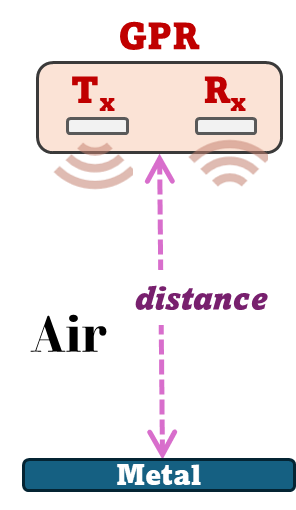

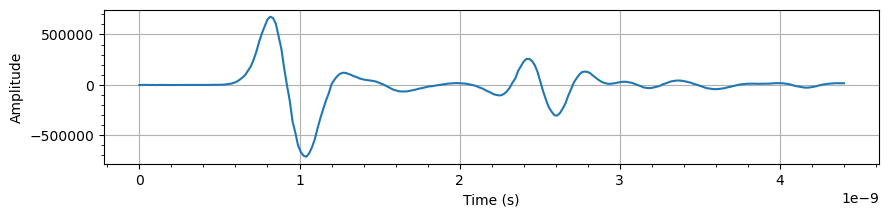

In [31]:
data = pd.read_csv('FILE__029.CSV')         # This file contains experimental A-scans for metal at true distance = 0.24 m from GPR 
A_exp = data.iloc[5:15].mean()              # Taking mean of 10 A-scans 
A_exp = A_exp - np.mean(A_exp)              # Subtracting mean amplitude
tw= 4.4e-9                                  # Total time of experimental A-scan is 4.4 ns. (actual total time was 8.87 ns, the samples after 4.4 ns are removed)
t_exp = np.linspace(0, tw, A_exp.shape[0])  # Forming the time vector

# Visualize
plt.plot(t_exp,A_exp);
plt.xlabel('Time (s)')
plt.ylabel('Amplitude') 
plt.grid(); 
plt.minorticks_on()

### A-scan from 2D FDTD simulation

In [4]:
tw = t_exp[-1];                             # Simulation time window, tw = expt time window

def model_2D(p1,c1,dep, p2,c2, waveform, freq, bs, dd):
    b=0.02
    X=0.4; Y=0.5; dx=0.001; Z=dx; gpr_Y = dep+b+dd; freq = freq; Tx=X/2-0.04
    with open("Calib.in", "w") as f:
        f.write(f"#title: Calib \n#domain: {X} {Y} {Z}\n#dx_dy_dz: {dx} {dx} {dx}")
        f.write(f"\n#time_window: {tw} \n#material: {p1} {c1} 1 0 mat1 \n#material: {p2} {c2} 1 0 mat2")
        f.write(f"\n#waveform: {waveform} 1 {freq} my_wave")
        f.write(f"\n#hertzian_dipole: z {Tx} {gpr_Y} 0 my_wave\n#rx: {Tx+bs} {gpr_Y} 0")
        f.write(f"\n#box: 0 {b} 0 {X} {dep+b} {Z} mat1")        
        f.write(f"\n#box: {X/2-0.1} {dep+b} 0 {X/2+0.1} {dep+b+2*dd} {Z} mat2")        
        f.write(f"\n#box: 0 {b-.01} 0 {X} {b} {Z} pec")
        f.write(f"\n#geometry_view: 0 0 0 {X} {Y} {Z} {dx} {dx} {dx} Calib n\n")
        f.close()

    api("Calib.in", geometry_only=False, gpu=[1])
    hf2 = h5py.File("Calib.out", 'r', libver='latest', swmr=True)
    Ascan = hf2['rxs/rx1/Ez'][:]
    hf2.close()
    free_gpu_cache();
    clear_output()
    return Ascan

### Bayesian Optimization for optimizing intrinsic radar parameters

In [5]:
# Bayesian Optimization
Opt_MaxGA=[]
for i in range(1):                              # Running optimization 1 time. In the actual study, mean of 5 runs were reported as the final result
    def mae_func(p2,c2, bs, dd, freq):
        sim = model_2D(p1 = 1.01,               # p1 = Permittivity of air 
                       c1 = 0,                  # c1 = Conductivity of air (S/m)
                       p2 = p2,                 # p2 = 'ε_g' in the paper 
                       c2 = c2,                 # c2 = 'σ_g' in the paper (S/m) 
                       dep = 0.24,              # dep = depth or distance of metal from GPR -- KNOWN in this case
                       waveform = "gaussian",   # waveform type
                       freq = freq,             # freq = center frequency 
                       bs = bs,                 # bs = bistatic separation
                       dd = dd                  # dd = 'd_g' in the paper  
                       )
        vector1,vector2 = signal_length_matching(A_exp,sim)
        
        vector2 = np.array(vector2)
        vector2 = vector2/(np.max(abs(vector2))) 
        result1 = -100*np.sqrt(np.sum((vector1 - vector2)**2))/(np.sqrt(np.sum(vector1**2)))
        
        return result1

    bounds = {'p2':(1,3),
              'c2':(0, 0.03),
              'dd':(0.005, 0.03), 
              'bs':(0.055, 0.065), 
              'freq':(1e9,3e9)
              }
    optimizer = BayesianOptimization(f=mae_func, 
                                     pbounds=bounds, 
                                     allow_duplicate_points=True
                                     )
    
    optimizer.maximize(init_points=400, n_iter=120)
    print("Optimization completed successfully."); 
    Opt_MaxGA.append((i + 1,optimizer.max))
    
for serial, result in Opt_MaxGA:
    print(f"Opt. {serial}: {result}")

| 520       | -84.47    | 0.05558   | 0.009608  | 0.009148  | 2.128e+09 | 1.939     |
Optimization completed successfully.
Opt. 1: {'target': -12.668020932695775, 'params': {'bs': 0.057407814721762956, 'c2': 0.0039996644986813054, 'dd': 0.025901378948075187, 'freq': 1372742463.741788, 'p2': 1.1824236195933762}}


### Calibrated model's response

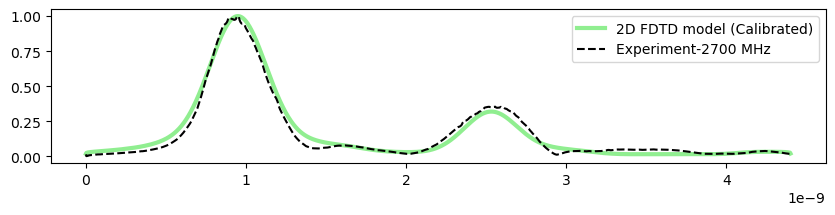

In [35]:
# Define the optimized parameter values
p1=1.01; 
c1=0; 
dep=0.24; 
waveform = "gaussian"; 
p2 = result['params']['p2']; 
c2 = result['params']['c2'];  
bs = result['params']['bs']; 
dd = result['params']['dd'];
freq=result['params']['freq'];

sim = model_2D(p1=p1, c1=c1, dep=dep, p2=p2,c2=c2, waveform=waveform, freq=freq, bs=bs, dd=dd)
t = np.linspace(0, tw, sim.shape[0])

a, b = signal_length_matching(A_exp,sim)
plt.plot(t, b, label='2D FDTD model (Calibrated)', color='lightgreen', linewidth=3); 
plt.plot(t, a, label='Experiment-2700 MHz', linestyle='--', color='black');   
plt.legend()
re = 100*np.sqrt(np.sum((a - b)**2))/(np.sqrt(np.sum(a**2)));